In [ ]:
# ─── GPU CHECK ────────────────────────────────────────────────────────────────
!nvidia-smi

# ─── TENSORFLOW SETUP ─────────────────────────────────────────────────────────
import tensorflow as tf

# List GPUs
gpus = tf.config.list_physical_devices('GPU')
if not gpus:
    print("❌ No GPU detected by TensorFlow. Make sure your runtime is set to GPU.")
else:
    # Enable memory growth to avoid full-GPU allocation
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(f"✅ TensorFlow sees {len(gpus)} physical GPU(s) and {len(logical_gpus)} logical GPU(s).")

# ─── PYTORCH SETUP ────────────────────────────────────────────────────────────
import torch

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🗄️  PyTorch will use: {device}")

# ─── USAGE EXAMPLE ────────────────────────────────────────────────────────────
# When you build your model and load data, remember:
# model = MyModel(...).to(device)
# data = data.to(device)
# target = target.to(device)
# ... then forward/backward as usual.

Wed May 21 10:44:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
!pip install mne

# Modelo EEGNet


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]

=== GLOBAL PRE‑TRAIN ===
Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.5458 - loss: 1.1128 - val_accuracy: 0.6582 - val_loss: 0.6793 - learning_rate: 0.0010
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.6045 - loss: 0.7651 - val_accuracy: 0.6582 - val_loss: 0.6551 - learning_rate: 0.0010
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.6040 - loss: 0.7247 - val_accuracy: 0.6582 - val_loss: 0.6477 - learning_rate: 0.0010
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.6415 - loss: 0.6681 - val_accuracy: 0.6582 - val_loss: 0.6405 - learning_rate: 0.0010
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.6620 - loss: 0.6497 - val_accuracy: 0.6582 - val_loss: 0.6425 - learning_rate: 0.0010
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 86m

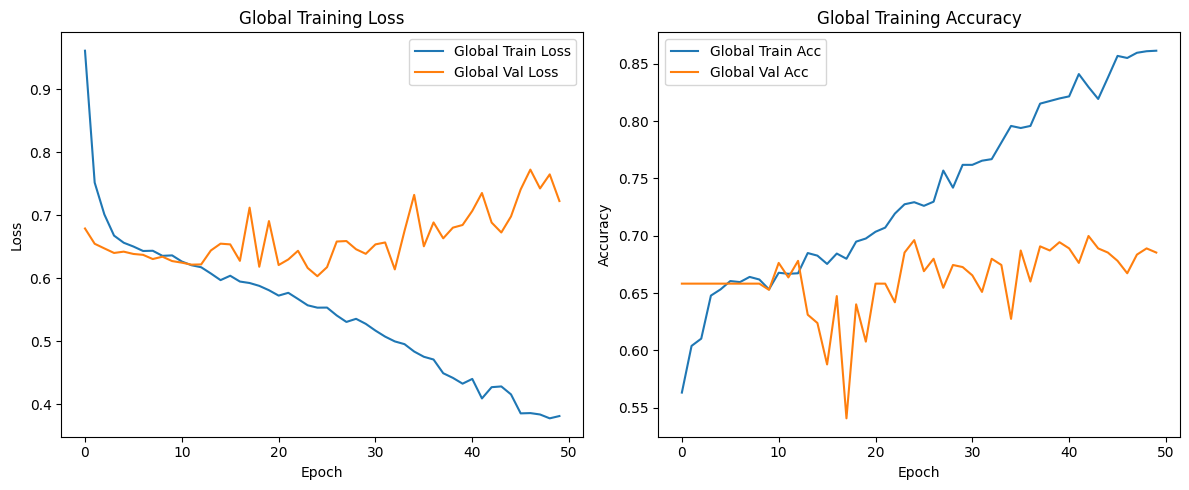

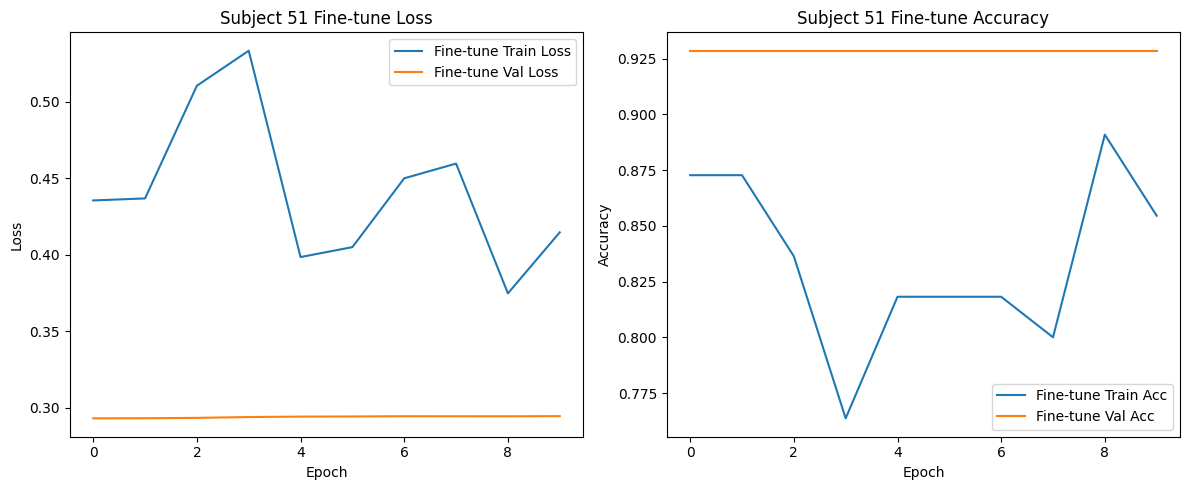

In [2]:
import numpy as np
import mne
from mne import concatenate_raws
from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, DepthwiseConv2D, SeparableConv2D, BatchNormalization,
    Activation, AveragePooling2D, Dropout, SpatialDropout2D, Flatten, Dense,
    ZeroPadding2D, MaxPool2D
)
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# =============================================
# USER‑CONFIGURABLE FLAGS
# =============================================
USE_EARLY_STOP = False      # True = enable early stop during global pre‑train
GENERAL_EPOCHS = 50       # cross‑subject pre‑train epochs
FINE_TUNE_SUBJECT = 51      # subject ID (1‑109) to fine‑tune on
FINE_TUNE_EPOCHS = 10      # subject‑specific fine‑tune epochs
# =============================================

# ---------------------------
# 1.  LOAD & NORMALISE ALL SUBJECTS
# ---------------------------
IMAGINE_LEFT_RIGHT = [4, 8, 12]
subjects = range(1, 52)
selected_channels = [
    'C3..', 'C4..', 'Fp1.', 'Fp2.', 'F7..', 'F3..', 'F4..', 'F8..',
    'T7..', 'T8..', 'P7..', 'P3..', 'P4..', 'P8..', 'O1..', 'O2..'
]

physionet_paths = np.concatenate([
    eegbci.load_data(subj, IMAGINE_LEFT_RIGHT, path=r"C:\root\mne_data")
    for subj in subjects
])

raws = []
for p in physionet_paths:
    r = mne.io.read_raw_edf(p, preload=True, stim_channel='auto', verbose='WARNING')
    data = r.get_data()
    data = (data - data.mean(axis=1, keepdims=True)) / data.std(axis=1, keepdims=True)
    r._data = data.astype(np.float64, copy=False)  # keep float64 for resample
    raws.append(r)

# resample each to lowest sfreq before concatenation
sfreqs = [r.info['sfreq'] for r in raws]
target_sfreq = int(min(sfreqs))
for r in raws:
    if r.info['sfreq'] != target_sfreq:
        r.resample(target_sfreq, npad='auto')
raw = concatenate_raws(raws)
raw.pick_channels(selected_channels)

# ---------------------------
# 2.  FILTER‑BANK EPOCHS HELPER
# ---------------------------

def build_filterbank_epochs(raw_input, bands=((7., 13.), (13., 19.), (19., 30.))):
    band_data, y_local = [], None
    events_all, _ = mne.events_from_annotations(raw_input)
    for l, h in bands:
        rb = raw_input.copy().filter(l, h, fir_design='firwin', verbose=False)
        epochs = mne.Epochs(
            rb, events_all, event_id=dict(T1=1, T2=2),
            tmin=0.5, tmax=2.5,
            proj=False,
            picks=mne.pick_types(rb.info, eeg=True, exclude='bads'),
            baseline=None,
            reject=None,
            preload=True,
            verbose=False,
        )
        if len(epochs) == 0:
            continue
        band_data.append((epochs.get_data() * 1e6).astype(np.float32))
        if y_local is None:
            y_local = epochs.events[:, -1] - 1
    X_fb = np.concatenate(band_data, axis=1)
    return X_fb, y_local

# global dataset
X, y = build_filterbank_epochs(raw)

# ---------------------------
# 3.  NORMALISE TRIALS & SPLIT
# ---------------------------
X_reshaped = X.reshape(X.shape[0], X.shape[1], -1)
for i in range(X_reshaped.shape[0]):
    X_reshaped[i] = StandardScaler().fit_transform(X_reshaped[i].T).T
X = X_reshaped.reshape(X.shape)

Y = tf.keras.utils.to_categorical(y, 2)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=y)

# add channel dim for Keras
X_train = X_train.transpose(0, 1, 2)[..., np.newaxis]
X_test = X_test.transpose(0, 1, 2)[..., np.newaxis]

# ---------------------------
# 4.  EEGNet ARCHITECTURE
# ---------------------------

def EEGNet(nb_classes, Chans, Samples,
           dropoutRate=0.5, kernLength=64,
           F1=16, D=1, F2=64, F3=64):
    inp = Input(shape=(Chans, Samples, 1))
    # Block 1
    x = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(inp)
    x = BatchNormalization()(x)
    x = DepthwiseConv2D((Chans, 1), depth_multiplier=D, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = SpatialDropout2D(0.3)(x)
    x = AveragePooling2D((1, 4))(x)
    # Block 2
    x = SeparableConv2D(F2, (1, 16), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 8))(x)
    x = Dropout(dropoutRate)(x)
    # Block 3
    x = ZeroPadding2D(((4, 3), (2, 1)))(x)
    x = Conv2D(F3, (8, 4), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = MaxPool2D((1, 4))(x)
    x = Dropout(dropoutRate)(x)
    # Block 4
    x = SeparableConv2D(F3, (1, 8), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = MaxPool2D((1, 2))(x)
    x = Dropout(dropoutRate)(x)
    # Classifier
    x = Flatten()(x)
    x = Dense(128, activation='elu')(x)
    x = Dropout(dropoutRate)(x)
    out = Dense(nb_classes, activation='softmax')(x)
    return Model(inp, out)

def EEGTCNet(nb_classes, Chans, Samples,
           dropoutRate=0.5, kernLength=64,
           F1=32, D=2, F2=64, F3=64):
    inp = Input(shape=(Chans, Samples, 1))

    # Block 1: Temporal and Spatial Convolution
    x = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(inp)
    x = BatchNormalization()(x)
    x = DepthwiseConv2D((Chans, 1), depth_multiplier=D, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = SpatialDropout2D(0.3)(x)
    x = AveragePooling2D((1, 4))(x)

    # Block 2: Separable Convolution
    x = SeparableConv2D(F2, (1, 16), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 8))(x)
    x = Dropout(dropoutRate)(x)

    # Block 3: Final lightweight Convolution
    x = SeparableConv2D(F3, (1, 8), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = MaxPool2D((1, 2))(x)
    x = Dropout(dropoutRate)(x)

    # Classifier
    x = Flatten()(x)
    x = Dense(64, activation='elu')(x)
    x = Dropout(dropoutRate)(x)
    out = Dense(nb_classes, activation='softmax')(x)

    return Model(inp, out)

#model = EEGNet(2, X_train.shape[1], X_train.shape[2])
model = EEGTCNet(2, X_train.shape[1], X_train.shape[2])
model.compile(
    AdamW(1e-3, weight_decay=1e-4),
    CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

# callbacks
callbacks_global = [tf.keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5, min_lr=1e-5, verbose=1)]
if USE_EARLY_STOP:
    callbacks_global.append(tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=1))

# ---------------------------
# 5.  GLOBAL PRE‑TRAIN
# ---------------------------
print("\n=== GLOBAL PRE‑TRAIN ===")
history_global = model.fit(
    X_train, y_train,
    batch_size=10,
    epochs=GENERAL_EPOCHS,
    validation_split=0.2,
    callbacks=callbacks_global,
    verbose=1
)

print("\nCross‑subject test scores:")
y_pred_global = model.predict(X_test).argmax(axis=-1)
y_true_global = y_test.argmax(axis=-1)
print(f"Test Accuracy: {accuracy_score(y_true_global, y_pred_global):.4f}, F1: {f1_score(y_true_global, y_pred_global):.4f}\n")

# ---------------------------
# 6.  SUBJECT‑SPECIFIC FINE‑TUNING
# ---------------------------
print(f"=== FINE‑TUNE ON SUBJECT {FINE_TUNE_SUBJECT:02d} ===")

# reload only target subject to avoid info leakage
subj_paths = eegbci.load_data(FINE_TUNE_SUBJECT, IMAGINE_LEFT_RIGHT, path=r"C:\root\mne_data")
raw_subj_list = []
for p in subj_paths:
    rs = mne.io.read_raw_edf(p, preload=True, stim_channel='auto', verbose='WARNING')
    d = rs.get_data()
    d = (d - d.mean(axis=1, keepdims=True)) / d.std(axis=1, keepdims=True)
    rs._data = d.astype(np.float64, copy=False)
    if rs.info['sfreq'] != target_sfreq:
        rs.resample(target_sfreq, npad='auto')
    raw_subj_list.append(rs)
raw_subj = concatenate_raws(raw_subj_list)
raw_subj.pick_channels(selected_channels)

X_subj, y_subj = build_filterbank_epochs(raw_subj)
X_subj_r = X_subj.reshape(X_subj.shape[0], X_subj.shape[1], -1)
for i in range(X_subj_r.shape[0]):
    X_subj_r[i] = StandardScaler().fit_transform(X_subj_r[i].T).T
X_subj = X_subj_r.reshape(X_subj.shape)
Y_subj = tf.keras.utils.to_categorical(y_subj, 2)

X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(
    X_subj, Y_subj, test_size=0.2, random_state=1, stratify=y_subj)
X_train_s = X_train_s.transpose(0, 1, 2)[..., np.newaxis]
X_val_s = X_val_s.transpose(0, 1, 2)[..., np.newaxis]

# freeze all but final dense layers
for layer in model.layers[:-2]:
    layer.trainable = False
model.compile(AdamW(1e-4), CategoricalCrossentropy(label_smoothing=0.05), metrics=['accuracy'])

history_ft = model.fit(
    X_train_s, y_train_s,
    batch_size=5,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=(X_val_s, y_val_s),
    verbose=1
)

print("Subject‑specific scores after fine‑tune:")
y_pred_ft = model.predict(X_val_s).argmax(axis=-1)
y_true_ft = y_val_s.argmax(axis=-1)
print(f"Accuracy: {accuracy_score(y_true_ft, y_pred_ft):.4f}, F1: {f1_score(y_true_ft, y_pred_ft):.4f}")

# ---------------------------
# 7.  PLOTS
# ---------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_global.history['loss'], label='Global Train Loss')
plt.plot(history_global.history['val_loss'], label='Global Val Loss')
plt.title('Global Training Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_global.history['accuracy'], label='Global Train Acc')
plt.plot(history_global.history['val_accuracy'], label='Global Val Acc')
plt.title('Global Training Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout()
plt.show()

# Fine‑tune curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_ft.history['loss'], label='Fine‑tune Train Loss')
plt.plot(history_ft.history['val_loss'], label='Fine‑tune Val Loss')
plt.title(f'Subject {FINE_TUNE_SUBJECT} Fine‑tune Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ft.history['accuracy'], label='Fine‑tune Train Acc')
plt.plot(history_ft.history['val_accuracy'], label='Fine‑tune Val Acc')
plt.title(f'Subject {FINE_TUNE_SUBJECT} Fine‑tune Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

# ─── INFERÊNCIA EM TODOS OS TRIALS DO SUJEITO ────────────────────────────────────

print(f"=== INFERÊNCIA EM TODOS OS 45 TRIALS DO SUJEITO {FINE_TUNE_SUBJECT:02d} ===")

# Recarregar todos os dados do sujeito (já feito previamente como raw_subj)
X_subj_all, y_subj_all = build_filterbank_epochs(raw_subj)
X_subj_r_all = X_subj_all.reshape(X_subj_all.shape[0], X_subj_all.shape[1], -1)
for i in range(X_subj_r_all.shape[0]):
    X_subj_r_all[i] = StandardScaler().fit_transform(X_subj_r_all[i].T).T
X_subj_all = X_subj_r_all.reshape(X_subj_all.shape)
Y_subj_all = tf.keras.utils.to_categorical(y_subj_all, 2)
X_subj_all = X_subj_all.transpose(0, 1, 2)[..., np.newaxis]

# Inferência
preds_all = model.predict(X_subj_all).argmax(axis=-1)
truth_all = y_subj_all

# Cálculo dos acertos e erros
correct_all = (preds_all == truth_all).sum()
total_all = len(truth_all)
accuracy_all = correct_all / total_all
errors_all = total_all - correct_all

print(f"Total Samples: {total_all}")
print(f"Correct Predictions: {correct_all}")
print(f"Incorrect Predictions: {errors_all}")
print(f"Accuracy: {accuracy_all:.4f}")


=== INFERÊNCIA EM TODOS OS 45 TRIALS DO SUJEITO 51 ===
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Total Samples: 69
Correct Predictions: 62
Incorrect Predictions: 7
Accuracy: 0.8986


In [ ]:

import os
import mne
import numpy as np
import matplotlib.pyplot as plt

# Seleção dos canais
selected_channels = [
    'C3..', 'C4..', 'Fp1.', 'Fp2.', 'F7..', 'F3..', 'F4..', 'F8..',
    'T7..', 'T8..', 'P7..', 'P3..', 'P4..', 'P8..', 'O1..', 'O2..'
]
target_sfreq = 160
label_names = ["Left", "Right"]
runs = [4, 8, 12]

base_data_dir = r"C:\Users\Chari\OneDrive\Documentos\GitHub\teste01\eeg_data\MNE-eegbci-data\files\eegmmidb\1.0.0"
base_dir = "plots"
os.makedirs(base_dir, exist_ok=True)

def build_filterbank_epochs(raw_input, bands=((7., 13.), (13., 19.), (19., 30.))):
    band_data, y_local = [], None
    events_all, _ = mne.events_from_annotations(raw_input)
    for l, h in bands:
        rb = raw_input.copy().filter(l, h, fir_design='firwin', verbose=False)
        epochs = mne.Epochs(
            rb, events_all, event_id=dict(T1=1, T2=2),
            tmin=0.5, tmax=2.5,
            proj=False,
            picks=mne.pick_types(rb.info, eeg=True, exclude='bads'),
            baseline=None,
            reject=None,
            preload=True,
            verbose=False,
        )
        if len(epochs) == 0:
            continue
        band_data.append((epochs.get_data() * 1e6).astype(np.float32))
        if y_local is None:
            y_local = epochs.events[:, -1] - 1
    X_fb = np.concatenate(band_data, axis=1)
    return X_fb, y_local

for subj_id in range(1, 53):
    print(f"Processando sujeito {subj_id:03d}...")
    try:
        subj_str = f"S{subj_id:03d}"
        subj_path = os.path.join(base_data_dir, subj_str)
        edf_files = [os.path.join(subj_path, f"{subj_str}R{run:02d}.edf") for run in runs]

        raw_list = []
        for file in edf_files:
            if not os.path.exists(file):
                continue
            raw = mne.io.read_raw_edf(file, preload=True, stim_channel='auto', verbose='WARNING')
            data = raw.get_data()
            data = (data - data.mean(axis=1, keepdims=True)) / data.std(axis=1, keepdims=True)
            raw._data = data.astype(np.float64, copy=False)
            if raw.info['sfreq'] != target_sfreq:
                raw.resample(target_sfreq, npad='auto')
            raw_list.append(raw)

        if not raw_list:
            print(f"Nenhum dado encontrado para o sujeito {subj_id:03d}")
            continue

        raw_concat = mne.concatenate_raws(raw_list)
        raw_concat.pick_channels(selected_channels)

        X, y = build_filterbank_epochs(raw_concat)
        subj_dir = os.path.join(base_dir, f"subject_{subj_id:02d}")
        os.makedirs(subj_dir, exist_ok=True)

        for i, (trial, label) in enumerate(zip(X, y)):
            label_str = label_names[label]
            plt.figure(figsize=(10, 5))
            for ch in range(trial.shape[0]):
                plt.plot(trial[ch] + ch * 50, linewidth=0.8)
            plt.title(f"Sujeito {subj_id:02d} - Trial {i:02d} - {label_str}")
            plt.xlabel("Amostras")
            plt.ylabel("Canal EEG")
            plt.tight_layout()
            plt.savefig(os.path.join(subj_dir, f"sample_{i:02d}_{label_str}.png"))
            plt.close()
    except Exception as e:
        print(f"Erro com sujeito {subj_id:03d}: {e}")


Processando sujeito 001...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Processando sujeito 002...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Processando sujeito 003...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Processando sujeito 004...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Processando sujeito 005...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Processando sujeito 006...
NOTE: pick_channels() is a legacy function. New code 